### The following is the code used to solve the No Moving Cost - MDP presented in the paper

- Here we will import the relevant packages
- We will define the MDP as defined in the paper
- We will then compute the results (fixed seed of 42 to ensure replicability)
- **Warning this code takes at least a couple of hours to fully run, but it does run**

### Importing relevant Packages

In [20]:
import itertools
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
import torch

plt.style.use('science')
plt.rcParams['figure.figsize'] = [6, 4]

In [21]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


#### Here I am using my 3060 GPU to speed up compuation:

In [22]:
print(torch.version.cuda)

11.8


#### We Define our MDP
- State Space
- Action Space
- Transition Probabilities
- Reward Function

### State and Action Space

In [23]:

from enum import Enum


class Location(Enum):
    POOR_COUNTRY = 0
    RICH_COUNTRY = 1


class Education(Enum):
    HIGH_SCHOOL = 0
    COLLEGE = 1


class CurrentLocation(Enum):
    HOME_COUNTRY = 0
    AWAY = 1


class RelationshipStatus(Enum):
    MARRIED = 0
    SINGLE = 1


class Action(Enum):
    MIGRATE = 0
    NOT_MIGRATE = 1


class StateSpace:
    def __init__(self, phi, y, c, omega, tau, epsilon):
        self.phi = phi
        self.y = y
        self.c = c
        self.omega = omega
        self.tau = tau
        self.epsilon = epsilon

    def __eq__(self, other):
        if isinstance(other, StateSpace):
            return self.phi == other.phi and self.y == other.y and self.c == other.c and self.omega == other.omega and self.tau == other.tau and self.epsilon == other.epsilon
        return False

    def __hash__(self):
        return hash((self.phi, self.y, self.c, self.omega, self.tau, self.epsilon))

    def to_tensor(self):
        phi_tensor = torch.tensor(1 if self.phi == Location.RICH_COUNTRY else 0, dtype=torch.float32)
        y_tensor = torch.tensor(self.y, dtype=torch.float32)
        c_tensor = torch.tensor(self.c, dtype=torch.float32)
        omega_tensor = torch.tensor(1 if self.omega == Education.COLLEGE else 0, dtype=torch.float32)
        tau_tensor = torch.tensor(1 if self.tau == CurrentLocation.HOME_COUNTRY else 0, dtype=torch.float32)
        epsilon_tensor = torch.tensor(1 if self.epsilon == RelationshipStatus.MARRIED else 0, dtype=torch.float32)
        return torch.stack([phi_tensor, y_tensor, c_tensor, omega_tensor, tau_tensor, epsilon_tensor])

### Transition Probabilities

In [24]:
import numpy as np

def transition_probability(s, next_s, a, p1, p2, p3):
    probs = np.zeros(len(states))

    if a == Action.MIGRATE:
        for i, state in enumerate(states):
            if s == state:
                probs[i] = (1 - p1) if s.omega == Education.COLLEGE and s.tau == CurrentLocation.HOME_COUNTRY and s.epsilon == RelationshipStatus.SINGLE and s.phi == Location.RICH_COUNTRY else (1 - p2)
            elif s.omega == Education.COLLEGE and s.tau == CurrentLocation.HOME_COUNTRY and s.epsilon == RelationshipStatus.SINGLE and s.phi == Location.RICH_COUNTRY:
                probs[i] = p1
            else:
                probs[i] = p2

    else:
        for i, state in enumerate(states):
            if s == state:
                probs[i] = p3
            else:
                probs[i] = (1 - p3) / (len(states) - 1)

    probs /= np.sum(probs)
    return probs[states.index(next_s)]



In [25]:
states = list(itertools.product(Location, np.linspace(0, 2, 3), np.linspace(0, 2, 3), Education, CurrentLocation, RelationshipStatus))
states = [StateSpace(*s) for s in states]
actions = list(Action)


p1 = 0.87 #Probability of succesfully migrate if state has conditions //Proxied by Uk Visa success rate
p2 = 0.66 #Probability of succefully migrate //proxied by avg UK asylum offer rate
p3 = 0.90 #Probability of succefully not migrating given chosen not to

### Reward Function

In [26]:
def reward_function(s, next_s, a):
    YC = next_s.y - next_s.c
    reward = YC*10

    # Additional rewards or penalties based on other state variables
    if next_s.tau == CurrentLocation.HOME_COUNTRY:
        reward += 30
    if next_s.epsilon == RelationshipStatus.SINGLE:
        reward += 10
    if next_s.omega == Education.COLLEGE:
        reward += 20
    if next_s.phi == Location.RICH_COUNTRY:
        reward += 50
    # Normalize reward
    max_reward = 30 + 10 + 20 + 50 + 20
    min_reward = -2
    new_reward = (reward - min_reward) / (max_reward - min_reward)
    
    return new_reward

### Solving MDP using Value Iteration

In [27]:
# Precompute transition probabilities
transition_probabilities = {}
for s in states:
    for a in actions:
        for next_s in states:
            transition_probabilities[(s, a, next_s)] = transition_probability(s, next_s, a, p1, p2, p3)


This section borrows from Barton and Sutton(2015) and from Fedus et al (2019)

In [28]:
def calculate_gamma_intervals(beta, gamma_max, n_gamma):
    epsilon = 1e-8 #To avoid Beta = 0
    b = np.exp(np.log(1 - gamma_max ** (1 / (beta + epsilon))) / n_gamma)
    gamma_values = [(1 - b ** i) ** (beta + epsilon) for i in range(n_gamma + 1)]
    return gamma_values


In [29]:
import torch
import numpy as np

def value_iteration_gpu(states, actions, transition_probabilities, reward_function, beta, theta=1e-4, max_iter=500):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    state_tensors = [s.to_tensor() for s in states]
    state_tensors = torch.stack(state_tensors).to(device)

    gamma_values = np.array(calculate_gamma_intervals(beta, gamma_max=0.99, n_gamma=10))
    eps = 1e-16
    gamma_weights = (1 / (beta + eps)) * gamma_values ** (1 / (beta + eps) - 1)
    gamma_diffs = np.diff(gamma_values)

    V_all = torch.zeros((len(states), len(gamma_values)), device=device)

    for gamma_idx, gamma in enumerate(gamma_values):
        V = torch.zeros(len(states), device=device)

        for _ in range(max_iter):
            delta_V = 0
            new_V = torch.zeros(len(states), device=device)
            
            action_values = []
            for a in actions:
                next_state_values = V.unsqueeze(1).repeat(1, len(states))
                transition_probabilities_tensor = torch.tensor([[transition_probabilities[(s, a, next_s)] for next_s in states] for s in states], device=device)
                rewards = torch.tensor([[reward_function(s, next_s, a) for next_s in states] for s in states], device=device)

                values = torch.sum(transition_probabilities_tensor * (rewards + gamma * next_state_values), dim=1)
                action_values.append(values)

        new_V, _ = torch.max(torch.stack(action_values, dim=1), dim=1)
        delta_V = torch.max(torch.abs(V - new_V))

        if delta_V < theta:
            break

        V = new_V

        V_all[:, gamma_idx] = V

    policy = {}
    for i, s in enumerate(states):
        action_values = []
        for a in actions:
            q_values = []
            for gamma_idx, gamma in enumerate(gamma_values[:-1]):
                next_state_values = torch.tensor([V_all[next_state_idx, gamma_idx] for next_state_idx, next_s in enumerate(states)], device=device)
                transition_probabilities_tensor = torch.tensor([transition_probabilities[(s, a, next_s)] for next_s in states], device=device)
                rewards = torch.tensor([reward_function(s, next_s, a) for next_s in states], device=device)

                value = torch.sum(transition_probabilities_tensor * (rewards + gamma * next_state_values))
                q_values.append(value.item())

            hyperbolic_discounted_q_value = np.sum(np.array(q_values) * gamma_diffs * gamma_weights[:-1])
            action_values.append(hyperbolic_discounted_q_value)

        policy[s] = actions[np.argmax(action_values)]

    V_approx_hyperbolic = torch.sum(V_all * torch.tensor(gamma_weights, device=device), dim=1)
    V_cpu = {s: v.item() for s, v in zip(states, V_approx_hyperbolic)}

    return V_cpu, policy


### Running the MDP:
- Here we can toggle delta
- We fix delta to 0.99
- Later on!! Higher Beta means lower Present Bias

In [30]:
def simulate(initial_state, policy, num_iterations, beta, gam, p1, p2, p3, transition_probabilities):
    expected_utility = []
    migrate_count = 0
    rewards = []
    states_sequence = []
    actions_sequence = []

    state = initial_state
    for i in range(num_iterations):
        action = policy[state]
        probabilities = [transition_probabilities[(state, action, s_prime)] for s_prime in states]
        next_state = np.random.choice(states, p=probabilities)
        reward = reward_function(state, next_state, action)
        
        print(f"Iteration: {i + 1}")
        print(f"State: {state.__dict__}")
        print(f"Action: {action}")
        print(f"Next State: {next_state.__dict__}")
        print(f"Reward: {reward}")
        print()

        if action == Action.MIGRATE:
            migrate_count += 1

        rewards.append(reward)
        
        # Append current state and action to the sequences
        states_sequence.append(state.__dict__)
        actions_sequence.append(action)

        # Calculate expected utility using hyperbolic discounting
        discounted_rewards = [beta * (r * (gam **t)) for t, r in enumerate(rewards[1:], start=1)]
        expected_utility_t = rewards[0] + sum(discounted_rewards)
        expected_utility.append(expected_utility_t)

        state = next_state
        
    migration_percentage = ((migrate_count / num_iterations) * 100)
    return rewards, expected_utility, migration_percentage, states_sequence, actions_sequence

### Now we running the MDP for different levels of Present Bias:


#### Key Visualisations:
- Migrate Percentage given Beta Value
- Rewards and Expected Utility for Each Present Bias Value

In [31]:
def plot_results(beta, rewards, expected_utility):
    plt.figure(figsize=(18, 6))

    # Plot rewards
    plt.subplot(131)
    plt.plot(rewards)
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title(f'Beta: {beta}, Rewards (MC)')

    # Plot reward distribution
    plt.subplot(132)
    plt.hist(rewards, bins=10, density=True)
    plt.xlabel('Reward')
    plt.ylabel('Probability')
    plt.title(f'Beta: {beta}, Reward Distribution (MC)')

    # Plot expected utility
    plt.subplot(133)
    plt.plot(expected_utility)
    plt.xlabel('Iteration')
    plt.ylabel('Expected Utility')
    plt.title(f'Beta: {beta}, Expected Utility (MC)')

    plt.tight_layout()
    plt.show()

In [32]:
def calculate_migration_percentage_matrix(states_sequence, actions_sequence):
    counts = {
        "poor_country": 0,
        "rich_country": 0,
        "college": 0,
        "high_school": 0,
        "single": 0,
        "married": 0,
        "home_country": 0,
        "away": 0
    }
    
    migrate_counts = counts.copy()

    for state, action in zip(states_sequence, actions_sequence):
        if state['phi'] == Location.POOR_COUNTRY:
            counts["poor_country"] += 1
            if action == Action.MIGRATE:
                migrate_counts["poor_country"] += 1
        elif state['phi'] == Location.RICH_COUNTRY:
            counts["rich_country"] += 1
            if action == Action.MIGRATE:
                migrate_counts["rich_country"] += 1

        if state['omega'] == Education.COLLEGE:
            counts["college"] += 1
            if action == Action.MIGRATE:
                migrate_counts["college"] += 1
        elif state['omega'] == Education.HIGH_SCHOOL:
            counts["high_school"] += 1
            if action == Action.MIGRATE:
                migrate_counts["high_school"] += 1

        if state['epsilon'] == RelationshipStatus.SINGLE:
            counts["single"] += 1
            if action == Action.MIGRATE:
                migrate_counts["single"] += 1
        elif state['epsilon'] == RelationshipStatus.MARRIED:
            counts["married"] += 1
            if action == Action.MIGRATE:
                migrate_counts["married"] += 1

        if state['tau'] == CurrentLocation.HOME_COUNTRY:
            counts["home_country"] += 1
            if action == Action.MIGRATE:
                migrate_counts["home_country"] += 1
        elif state['tau'] == CurrentLocation.AWAY:
            counts["away"] += 1
            if action == Action.MIGRATE:
                migrate_counts["away"] += 1

    migration_percentages = {k: (migrate_counts[k] / counts[k]) if counts[k] > 0 else 0 for k in counts}

    return np.array([list(migration_percentages.values())])




### Initial State for Simlulation
- POOR
- Income = 0
- Cost of living = 2
- HIGH SCHOOL
- HOME COUNTRY
- SINGLE
- delta = 0.99

This proxies an individual living in a developing nation, who in faced with migration decision

Run codeblock below to begin MDP:

Iteration: 1
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 0, 'c': 2, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Action: Action.MIGRATE
Next State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 2.0, 'c': 0.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Reward: 0.3181818181818182

Iteration: 2
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 2.0, 'c': 0.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Action: Action.MIGRATE
Next State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 2.0, 'c': 2.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Reward: 0.6212121212121212

Iteration: 3
State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 2.0, 'c': 2.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.HOME_COUNT

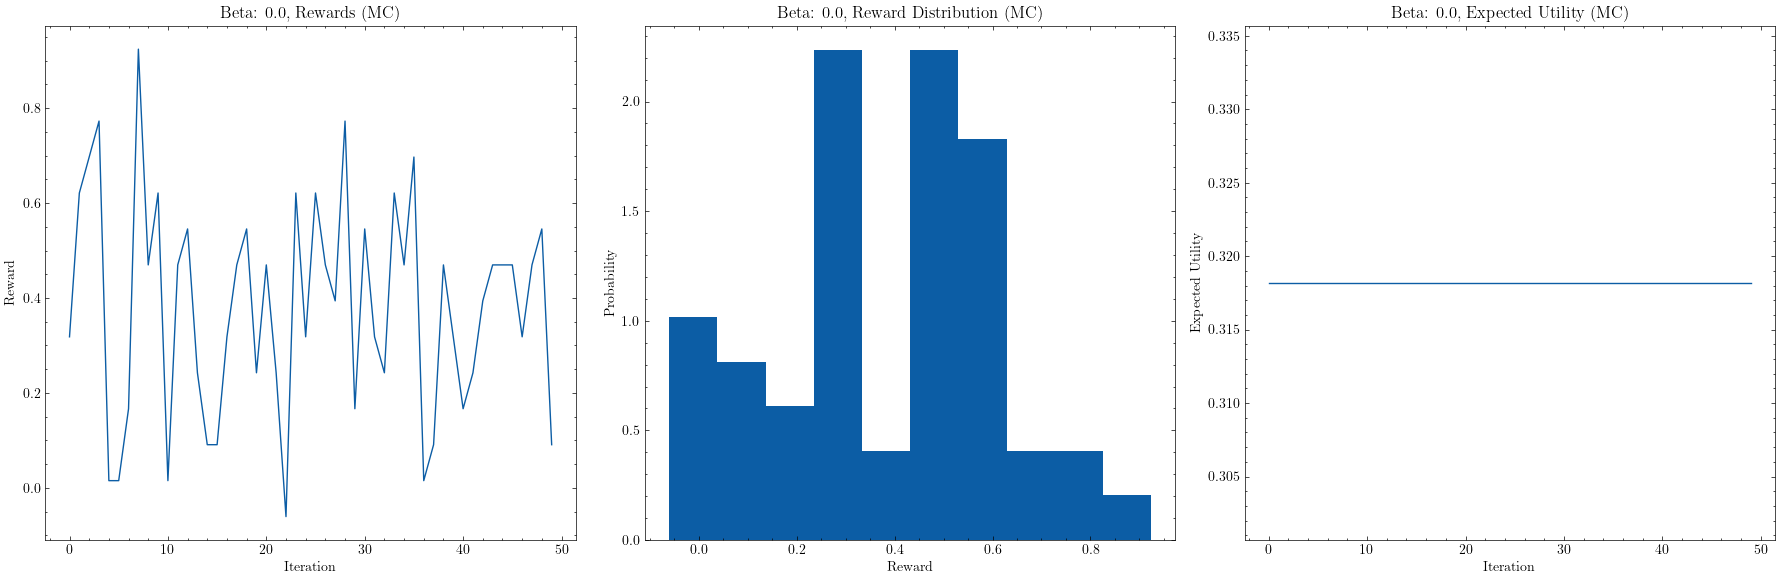

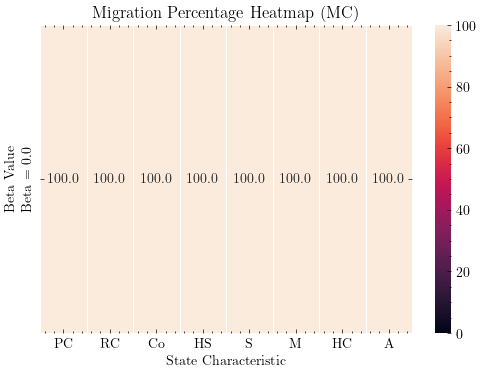

Iteration: 1
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 0, 'c': 2, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Action: Action.MIGRATE
Next State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 2.0, 'c': 2.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Reward: 0.4696969696969697

Iteration: 2
State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 2.0, 'c': 2.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Action: Action.MIGRATE
Next State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 1.0, 'c': 1.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Reward: 0.6212121212121212

Iteration: 3
State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 1.0, 'c': 1.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': 

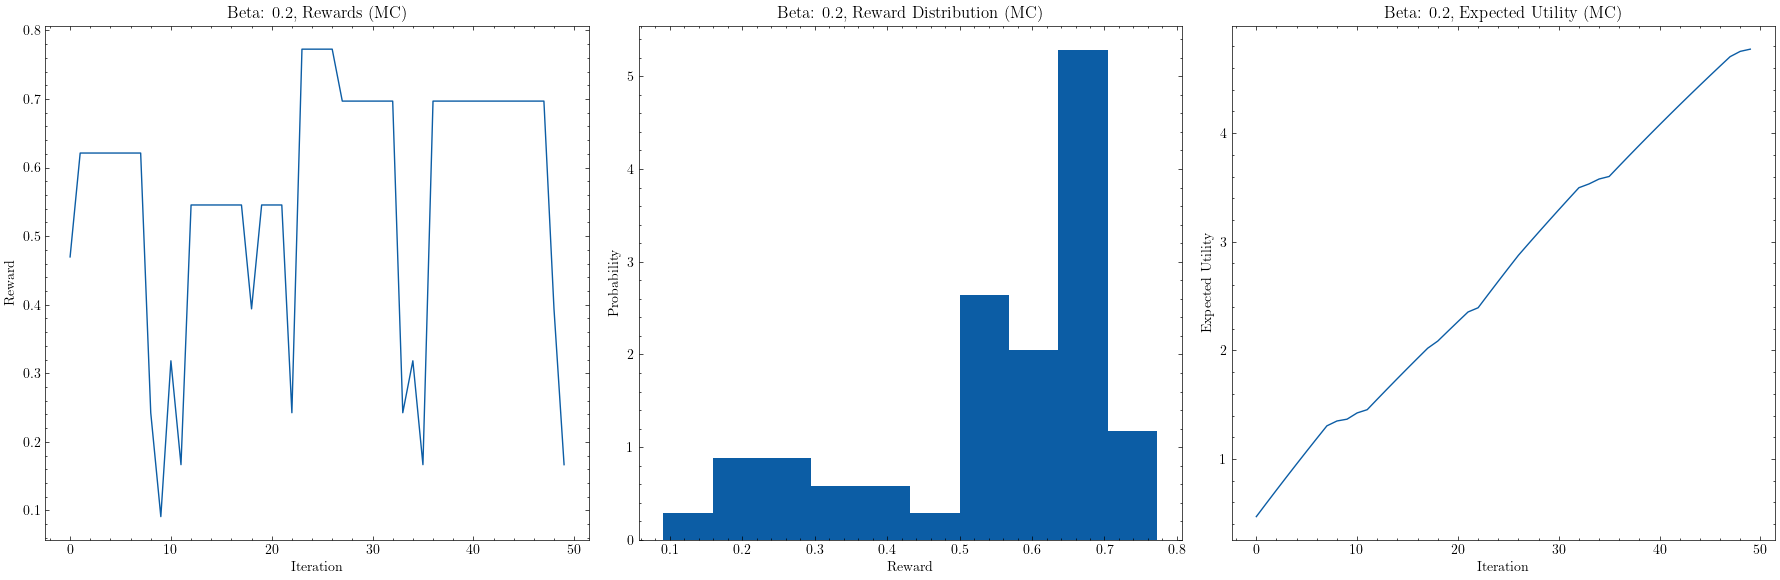

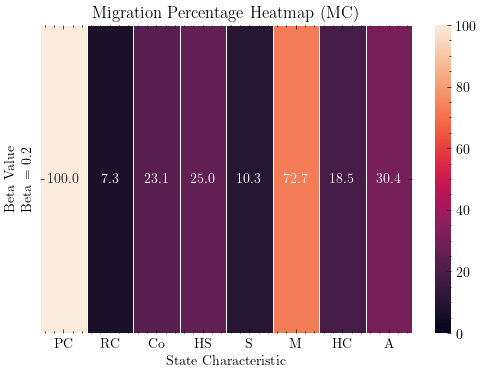

Iteration: 1
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 0, 'c': 2, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Action: Action.MIGRATE
Next State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 0.0, 'c': 0.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Reward: 0.3939393939393939

Iteration: 2
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 0.0, 'c': 0.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Action: Action.MIGRATE
Next State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 0.0, 'c': 2.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Reward: 0.3181818181818182

Iteration: 3
State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 0.0, 'c': 2.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWA

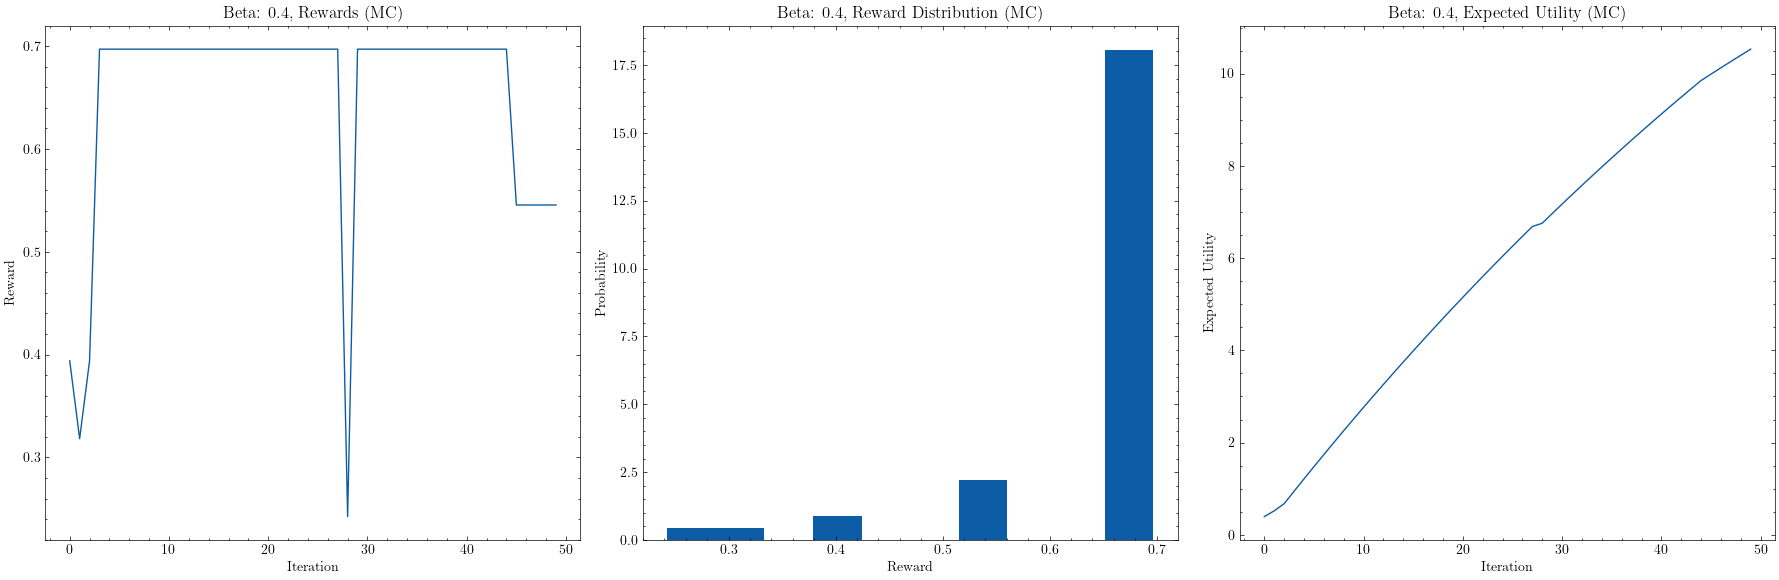

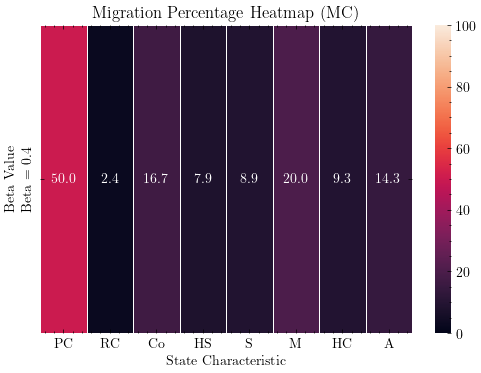

Iteration: 1
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 0, 'c': 2, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Action: Action.MIGRATE
Next State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 2.0, 'c': 1.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Reward: 0.4696969696969697

Iteration: 2
State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 2.0, 'c': 1.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Action: Action.MIGRATE
Next State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 1.0, 'c': 1.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Reward: 0.015151515151515152

Iteration: 3
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 1.0, 'c': 1.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>

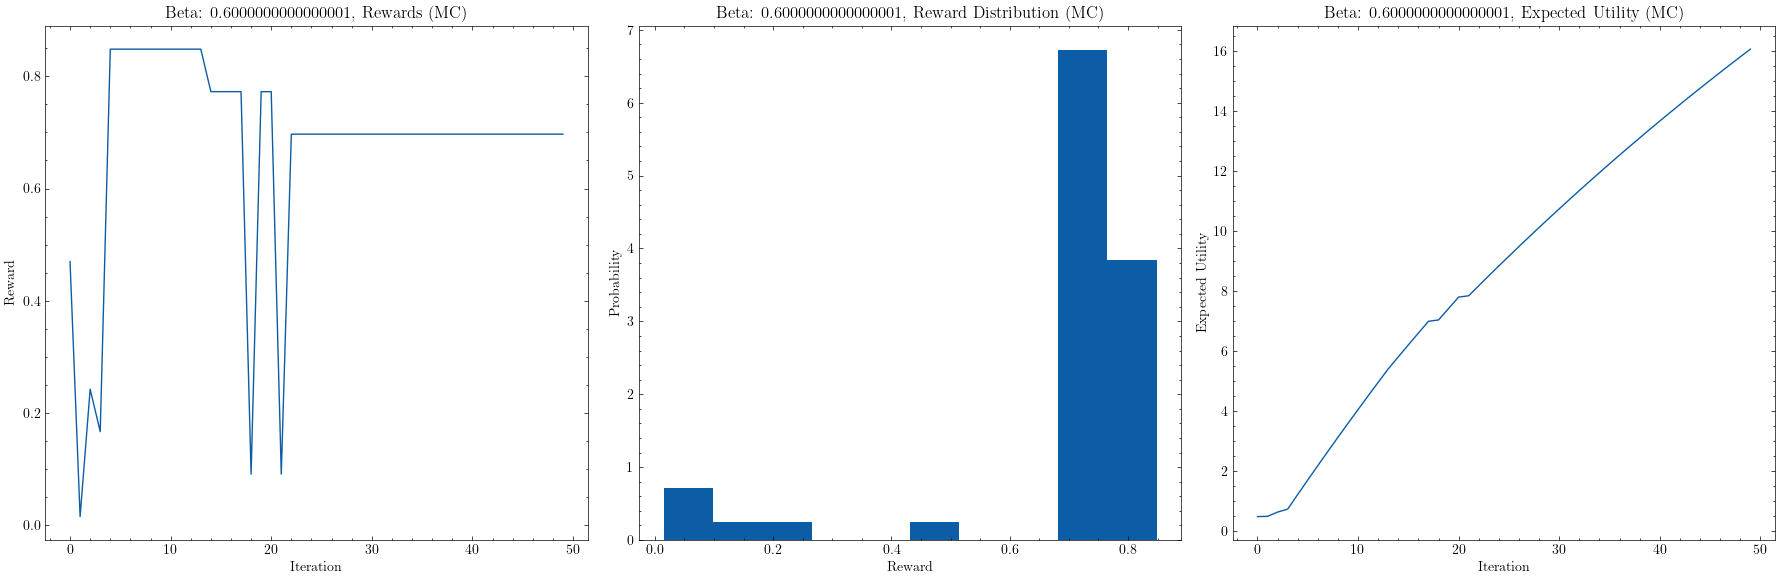

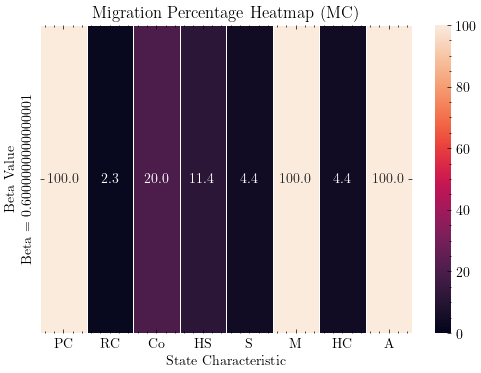

Iteration: 1
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 0, 'c': 2, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Action: Action.MIGRATE
Next State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 0.0, 'c': 2.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Reward: 0.6212121212121212

Iteration: 2
State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 0.0, 'c': 2.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Action: Action.NOT_MIGRATE
Next State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 0.0, 'c': 2.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Reward: 0.6212121212121212

Iteration: 3
State: {'phi': <Location.RICH_COUNTRY: 1>, 'y': 0.0, 'c': 2.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocatio

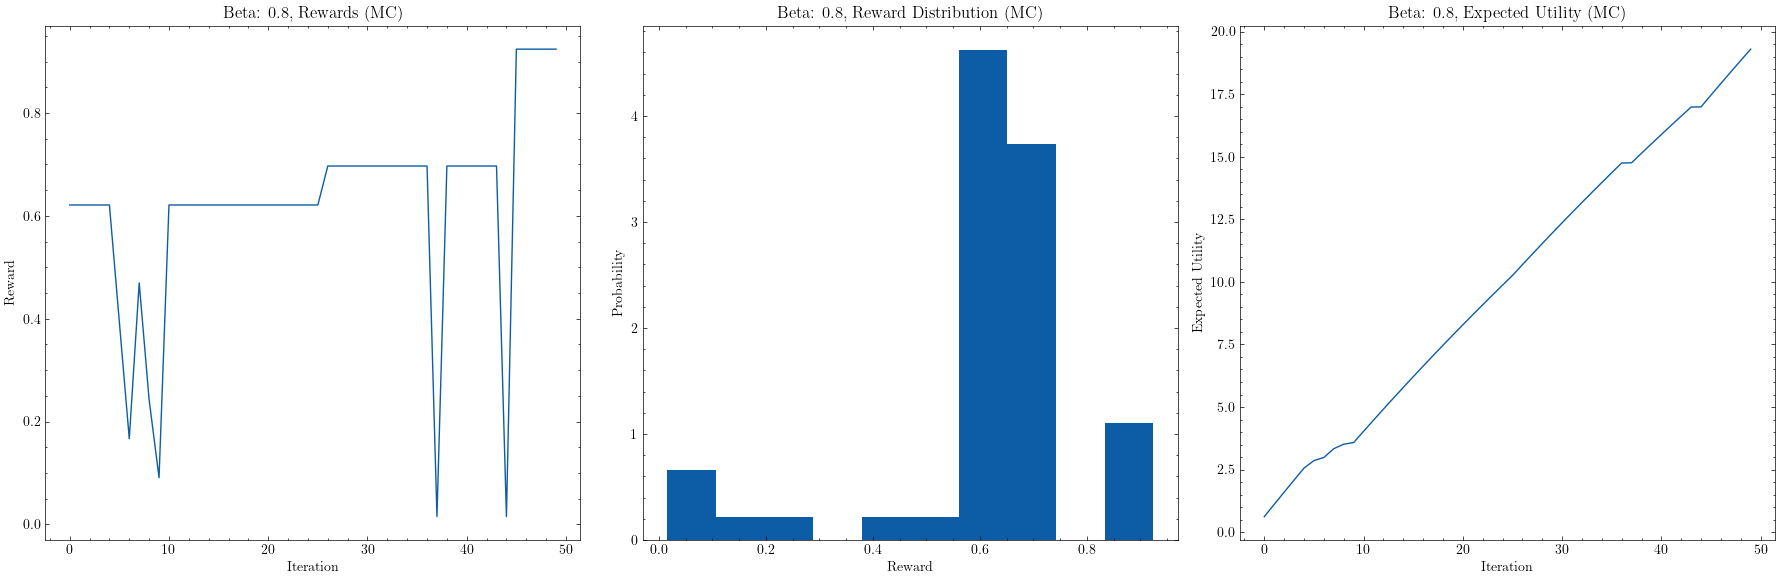

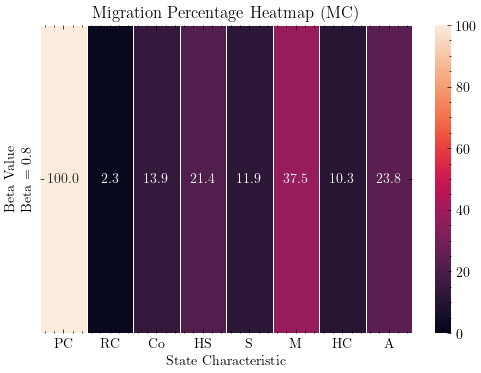

Iteration: 1
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 0, 'c': 2, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.HOME_COUNTRY: 0>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Action: Action.MIGRATE
Next State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 1.0, 'c': 2.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Reward: -0.06060606060606061

Iteration: 2
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 1.0, 'c': 2.0, 'omega': <Education.HIGH_SCHOOL: 0>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.MARRIED: 0>}
Action: Action.MIGRATE
Next State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 2.0, 'c': 0.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilon': <RelationshipStatus.SINGLE: 1>}
Reward: 0.3939393939393939

Iteration: 3
State: {'phi': <Location.POOR_COUNTRY: 0>, 'y': 2.0, 'c': 0.0, 'omega': <Education.COLLEGE: 1>, 'tau': <CurrentLocation.AWAY: 1>, 'epsilo

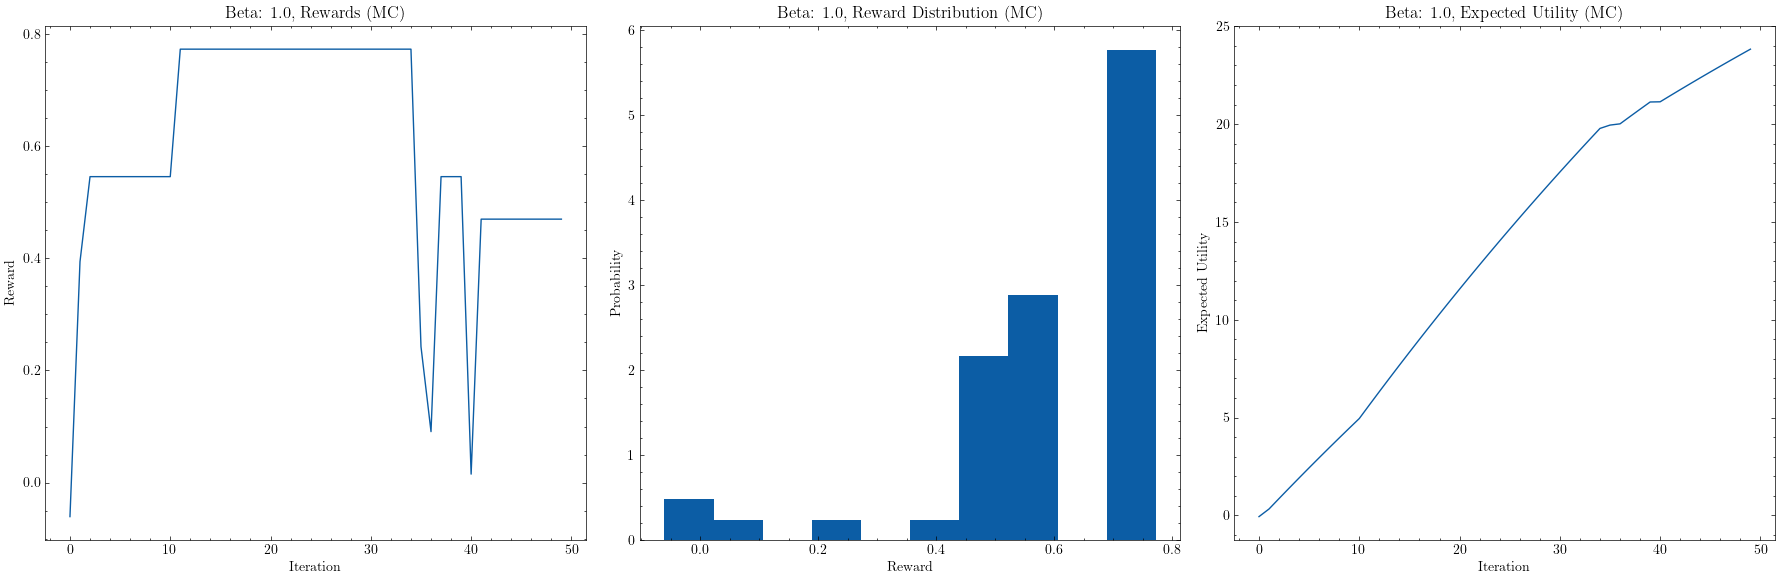

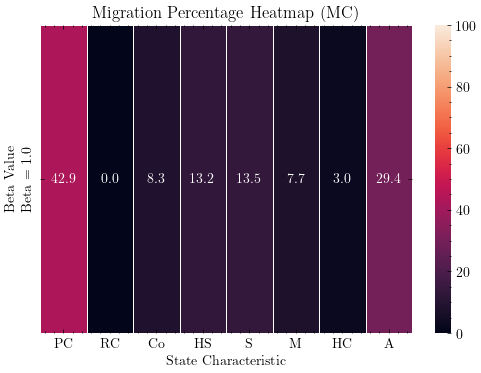

In [34]:
#Can never be too sure with setting seed, setting seed again to make sure we have replicability

import seaborn as sns

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

beta_values = np.linspace(0, 1, 6)
migration_percentages = []
gam = 0.99
num_iterations = 50
initial_state = StateSpace(Location.POOR_COUNTRY, 0, 2, Education.HIGH_SCHOOL, CurrentLocation.HOME_COUNTRY, RelationshipStatus.SINGLE)

for beta in beta_values:
    V, policy = value_iteration_gpu(states, actions, transition_probabilities, reward_function, beta)
    rewards, expected_utility, migration_percentage, states_sequence, actions_sequence = simulate(initial_state, policy, num_iterations, beta, gam, p1, p2, p3, transition_probabilities)
    plot_results(beta, rewards, expected_utility)
    migration_percentages.append(migration_percentage)
    
    # Create 1x1 matrices
    migration_matrix = calculate_migration_percentage_matrix(states_sequence, actions_sequence)


    import matplotlib.ticker as ticker

    # Create heatmaps for all state characteristics
    plt.figure()
    ax = sns.heatmap(migration_matrix * 100, annot=True, xticklabels=["PC", "RC", "Co", "HS", "S", "M", "HC", "A"], yticklabels=[f'Beta = {beta}'], vmin=0, vmax=100, linewidth=.5, fmt=".1f")
    sns.color_palette("mako", as_cmap=True)
    plt.xlabel('State Characteristic')
    plt.ylabel('Beta Value')
    plt.title('Migration Percentage Heatmap (MC)')

    # Format the color bar to display integers
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    plt.show()


### Plot Migration Percentage

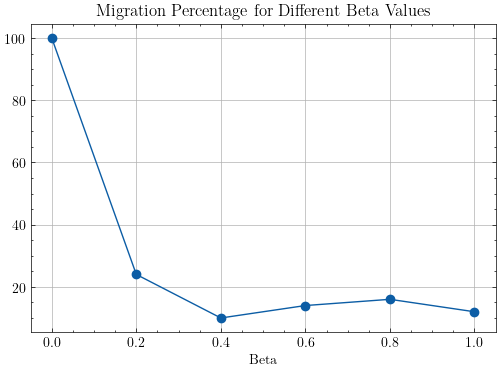

In [38]:
plt.plot(beta_values, migration_percentages, marker='o')
plt.xlabel('Beta')
plt.ylabel('% of Migrate Actions')
plt.title('Migration Percentage for Different Beta Values')
plt.grid(True)
plt.show()

In [36]:
migration_percentages

[100.0, 24.0, 10.0, 14.000000000000002, 16.0, 12.0]